# Py: Customer Churn Classification
**This notebook was originally created  by Josh Jaroudy for the Data Analytics Applications subject, as *Case Study 1* in the DAA M05 Classification and neural networks module.**

**The Data Analytics Application is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**

### Define the Problem:

Customer churn, also known as customer attrition, customer turnover or customer defection, is the loss of clients or customers. For many businesses, a high level of customer churn can negatively impact their profits, particularly because it is often quite costly for a business to acquire new customers.

For this reason, many businesses like to understand which customers are likely to churn in a given period. Armed with this information, businesses can employ different strategies to try to retain their customers.
This case study investigates the use of neural networks and gradient boosting machines for predicting which customers are likely to churn.

When trying to predict customer churn, it may seem like a relatively straightforward task to obtain some past customer data and use this to determine whether future customers will churn. However, the task of deciding exactly what the output of such a prediction model should be is quite complex, and heavily dependent on how the model will be used by the business.

### Purpose:

This notebook investigates the use of neural networks and gradient boosting machines for predicting which customers are likely to churn. This code is used in Case Study 1 in Module 5.

### References:
The dataset used in this notebook was sourced from a Kaggle competition  that aimed to predict customer churn behaviour for a telecommunications provider: https://www.kaggle.com/blastchar/telco-customer-churn.

This dataset contains 7,043 rows (one for each customer) and 21 features, including information about each customer’s:
- services with the company, such as phone, internet, online security, online backup, device protection, tech support, and streaming of TV and movies;
- account information, such as how long they have been a customer, contract, payment method, paperless billing, monthly charges and total charges; and
- demographic information, such as gender, age range, and whether they have a partner and dependents.

The response variable in the dataset is labelled ‘Churn’. It represents whether each customer left the service provider in the month preceding the data extract date. 

## Packages
This section imports the packages that will be required for this exercise/case study.

In [1]:
import pandas as pd # Pandas is used for data management.
import numpy as np # Numpy is used for mathematical operations.

# Matplotlib and Seaborn are used for plotting.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import os

import itertools # Used in the confusion matrix function

from tensorflow import keras # Keras, from the Tensorflow package is used for
                             # building the neural networks.

# The various functions below from the Scikit-learn package help with
# modelling and diagnostics.
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier # For building the GBM
from sklearn.metrics import auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.inspection import plot_partial_dependence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf

## Functions
The section below defines some general functions that are used in this notebook.
Other functions that are specific to each type of model are defined in the section for that model.

In [2]:
# Define a function to split the data into train, validation and test sets.
# This uses the `train_test_split` function from the sklearn package to do the 
# actual data splitting.
def create_data_splits(dataset, id_col, response_col):
    '''
    Splits the data into train, validation and test sets (64%, 16%, 20%)
    All columns on `dataset` other than the `id_col` and `response_col` will be
    used as features.
    Params:
    dataset: input dataset as a pandas data frame
    id_col: (str) the name of the column containing the unique row identifier
    response_col: (str) the name of the response column
    Returns:
    train_x: the training data (feature) matrix
    train_y: the training data response vector
    validation_x: the validation data (feature) matrix
    validation_y: the validation data response vector
    test_x: the test data (feature) matrix
    test_y: the test data response vector
    '''
    # Split data into train/test (80%, 20%).
    train_full, test = train_test_split(dataset, test_size = 0.2, random_state = 123)

    # Create a validation set from the training data (20%).
    train, validation = train_test_split(train_full, test_size = 0.2, random_state = 234)

    # Create train and validation data feature matrices and response vectors
    # For the response vectors, convert Churn Yes/No to 1/0

    feature_cols = [i for i in dataset.columns if i not in id_col + response_col]

    train_x = train[feature_cols]
    train_y = train[response_col].eq('Yes').mul(1)

    validation_x = validation[feature_cols]
    validation_y = validation[response_col].eq('Yes').mul(1)

    test_x = test[feature_cols]
    test_y = test[response_col].eq('Yes').mul(1)

    return train_x, train_y, validation_x, validation_y, test_x, test_y

In [3]:
# Define a function to print and plot a confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalise=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots a confusion matrix.
    Normalisation of the matrix can be applied by setting `normalise=True`.
    Normalsiation ensures that the sum of each row in the confusion matrix is 1.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True response')
    plt.xlabel('Predicted response')

## Data
This section:
- imports the data that will be used in the modelling;
- explores the data; and
- prepares the data for modelling.

### Import data
The below code will read it into a pandas data frame.

We read directly from a URL, but pandas can also read from a file.

In [4]:
dataset = pd.read_csv(
    'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/DAA_M05_CS1_data.csv', 
    header = 0)

### Explore data (EDA)
Prior to commencing modelling, it is always a good idea to look at the data to get an understanding of the:
* available features;
* the data types of the features (numeric, categorical, dates, etc.);
* the distribution and missingness of the features;
* correlations between features; and
* relationships between features and the response variable.

The code below looks at some of these components of the Telco dataset.

In [5]:
# Check the available features, their data types and their missingness.
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check the number of unique values for each feature.
dataset.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [7]:
# Print out the first 5 observations in the data.
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


###  Prepare data

Some data preparation is needed before the modelling can begin.

From the summaries in the EDA section above you can see that:
- `customerID` is the unique identifier for each observation;
- `Churn` is the response and takes values 'Yes' and 'No' with a 'Yes' rate of 26.5% (= 1,869/(5,174+1,869));
- `Tenure`, `MonthlyCharges` and `TotalCharges` are numeric features;
  - `TotalCharges` is stored as categorical;
- all other features are categorical (though many with only 2 levels); and
- missing values are not a significant concern.

In [8]:
# Define the ID and response columns
id_col = ['customerID']
response_col = ['Churn']

# Get the list of features by type.
# Categorical features can be identified as those columns with only a few levels.
# This code selects the list of features with < 6 levels and puts the names 
# into a list, excluding the id_col and response_col.
cat_cols = dataset.nunique()[dataset.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in id_col + response_col]

# Numerical features are left after the categorical features have been removed.
# List comprehension is used below to select the set of feature names not
# contained in the cat_cols, id_col, or response_col lists.
num_cols = [x for x in dataset.columns if x not in cat_cols + id_col + response_col]

# Convert TotalCharges to numeric and set equal to 0 where blank.
dataset.loc[dataset['TotalCharges'] == ' ','TotalCharges'] = 0
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'])

# Check the number of levels for each categorical feature and the
# response variable.
for cat_col in cat_cols + response_col:
    print(cat_col, dataset[cat_col].unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [9]:
# Check the updated feature types
dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Now that the data has been cleaned up, the marginal relationship between the features and the response can be analysed.

<AxesSubplot:xlabel='Feature_TotalCharges'>

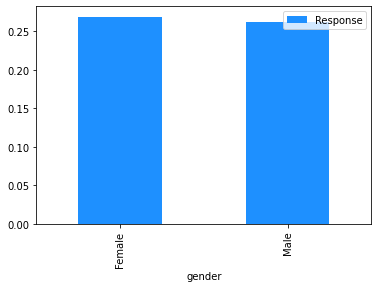

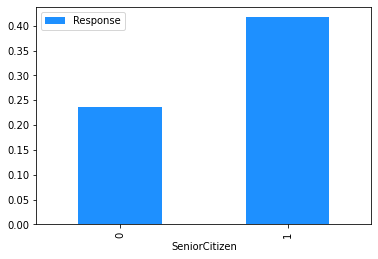

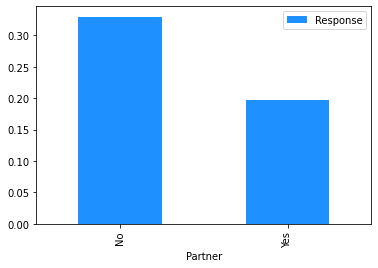

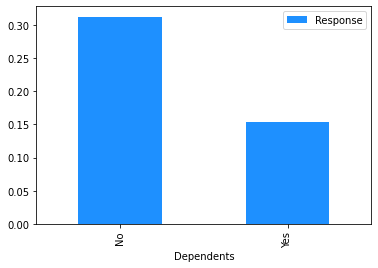

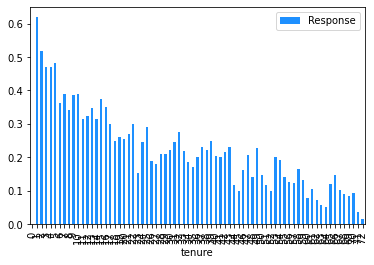

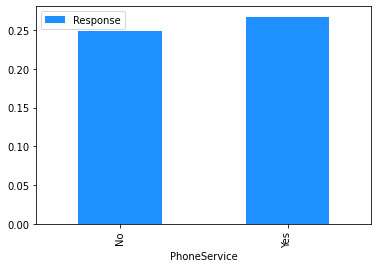

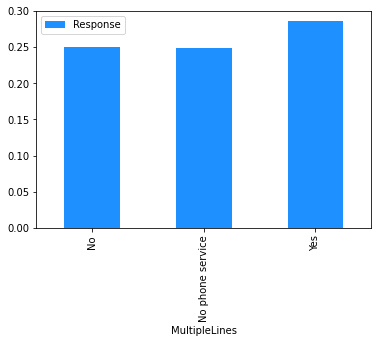

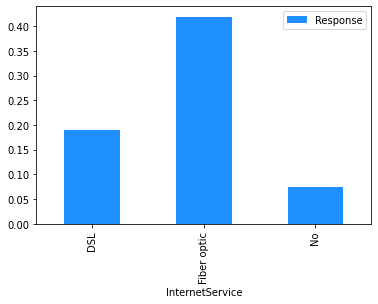

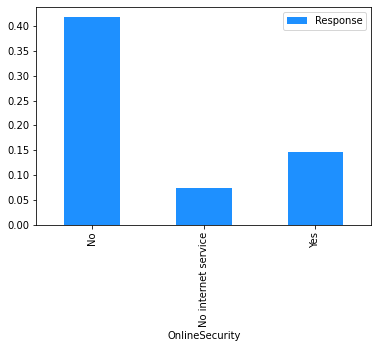

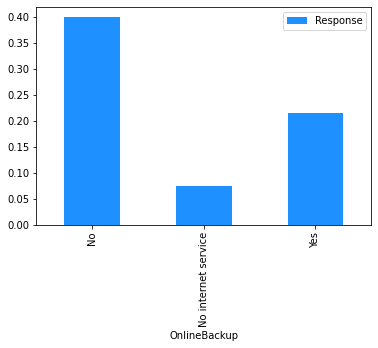

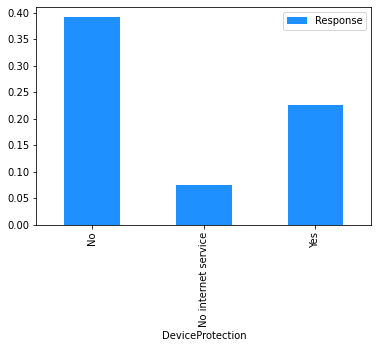

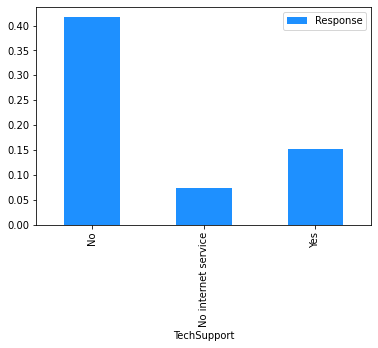

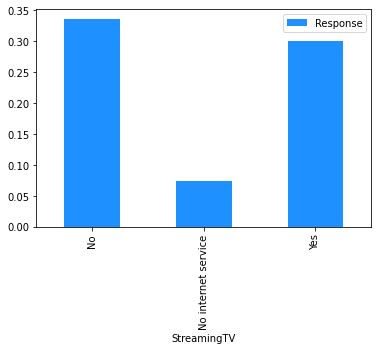

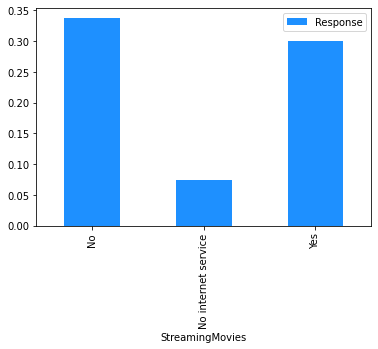

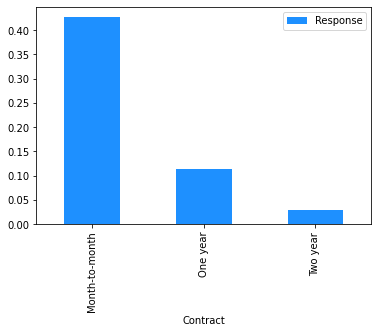

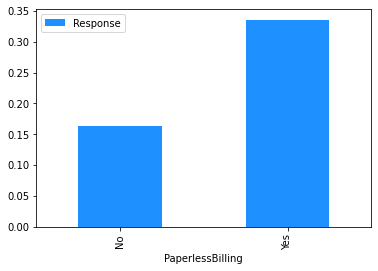

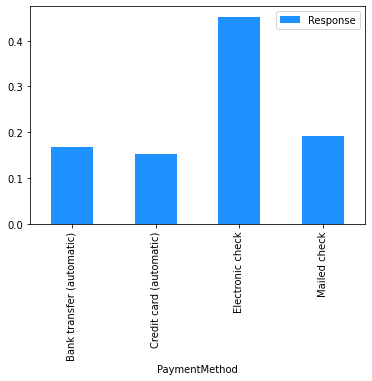

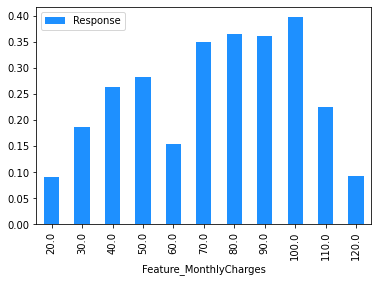

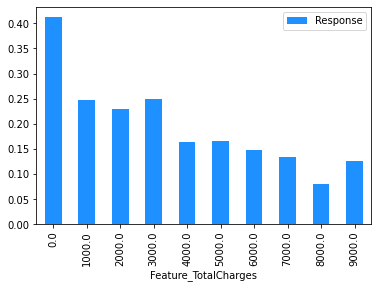

In [10]:
# Plot the mean churn rate by each of the candidate features.

# Loop over each feature.
for feature in [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'tenure',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod',
]:
    (
        # create a binary 1/0 response column, where 1 indicates Churn = 'Yes';
        # group by the values of the current feature;
        # calculate the mean of the response; and
        # plot.
        dataset[[feature]]
        .assign(Response=np.where(dataset.Churn == 'Yes', 1, 0))
        .groupby(feature)
        .agg('mean')
        .plot.bar(color='Dodgerblue')
    )


(
    # The same is done for MonthlyCharges except that the value is rounded
    # to the nearest $10 using np.round(, -1).
    dataset[['MonthlyCharges']]
    .assign(
        Feature_MonthlyCharges=np.round(dataset['MonthlyCharges'], -1),
        Response=np.where(dataset.Churn == 'Yes', 1, 0),
    )
    .drop(columns=['MonthlyCharges'])
    .groupby('Feature_MonthlyCharges')
    .agg('mean')
    .plot.bar(color='Dodgerblue')
)


(
    # TotalCharges is rounded to the nearest $1,000 using np.round(, -3).
    dataset[['TotalCharges']]
    .assign(
        Feature_TotalCharges=np.round(dataset['TotalCharges'], -3),
        Response=np.where(dataset.Churn == 'Yes', 1, 0),
    )
    .drop(columns=['TotalCharges'])
    .groupby('Feature_TotalCharges')
    .agg('mean')
    .plot.bar(color='Dodgerblue')
)


## Modelling
This section:
- fits some models; and
- evaluates the fitted models.

### Gradient Boosting Machine (GBM)

The first model to be fitted is a Gradient Boosting Machine (GBM).
GBM applies boosting (see Section 5.3.3 of Module 5) in the context of decision trees.

The GBM will be used as a benchmark to compare to a neural network fitted later on.

To fit the GBM, the `GradientBoostingClassifier()` from the sklearn package is used.

#### Prepare data
To prepare the data for the GBM model, the code below:
- one hot encodes the categorical features; and
- splits the data into train, validation, and test sets.

In [11]:
# One-hot encode categorical features including an indicator for NAs.
dataset_gbm = pd.get_dummies(dataset, columns=cat_cols, dummy_na=True)

# Split the data into train, valiation, and test sets.
train_gbm_x, train_gbm_y, \
validation_gbm_x, validation_gbm_y, \
test_gbm_x, test_gbm_y \
= create_data_splits(dataset_gbm, id_col, response_col)


#### Fit initial GBM (GBM 1)

To create and train the model, 20% of the training data will be used as an (internal) validation set for early stopping, to prevent overfitting. The model will stop training if no improvement on this validation data has been observed for 50 consecutive iterations.
This is specified with `validation_fraction = 0.2` and `n_iter_no_change = 50`.

Other hyperparameters used in the training:
- `n_estimators = 1000`: specifies a maximum of 1,000 trees;
- `learning_rate = 0.1`: sets the learning rate to 10%;
- `random_state = 1234`: initialises the random seed for the model, for reproducibility; and
- `verbose = 1`: requests additional information be printed during training.


In [12]:
# Specify the GBM model.
gbm_model = GradientBoostingClassifier(n_estimators = 1000,
                                       learning_rate = 0.1,
                                       validation_fraction = 0.2,
                                       n_iter_no_change = 50,
                                       verbose = 1,
                                       random_state = 1234)
# Train the model.
# 'train_gbm_y.values.ravel()' converts the series of response values into
# a 1D array which is the format expected by the .fit() method
gbm_model.fit(train_gbm_x, train_gbm_y.values.ravel())

      Iter       Train Loss   Remaining Time 
         1           1.1021            6.82s
         2           1.0617            7.96s
         3           1.0286            7.71s
         4           1.0003            7.72s
         5           0.9774            7.58s
         6           0.9570            7.43s
         7           0.9398            7.27s
         8           0.9251            7.16s
         9           0.9115            7.20s
        10           0.8997            7.16s
        20           0.8311            6.78s
        30           0.7995            6.65s
        40           0.7822            6.48s
        50           0.7657            6.36s
        60           0.7534            6.24s
        70           0.7434            6.18s
        80           0.7341            6.06s


GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=50,
                           random_state=1234, validation_fraction=0.2,
                           verbose=1)

#### Evaluate GBM 1
The code below looks at some basic goodness of fit measures.

In [13]:
# Score the validation dataset.

# Obtain the predicted churn probabilities (Y_hat).
# The code below returns these in an array of form ([Prob(0), Prob(1)]).
# Keep the Prob(1) values only, i.e. the predicted churn probability (Y_hat).
train_y_preds = gbm_model.predict_proba(train_gbm_x)[:, 1] 
validation_y_preds = gbm_model.predict_proba(validation_gbm_x)[:, 1] 

# Obtain the predicted churn outcomes, G(X).
# Returns the predicted class as 0 for 'no churn' or 1 for 'churn'.
train_y_class = gbm_model.predict(train_gbm_x)
validation_y_class = gbm_model.predict(validation_gbm_x)

In [14]:
# Calculate the AUC on train and validation data.
{'train': roc_auc_score(train_gbm_y.values.ravel(), train_y_preds),
 'validation': roc_auc_score(validation_gbm_y.values.ravel(), validation_y_preds)}

{'train': 0.8774950558946257, 'validation': 0.8589570358298064}

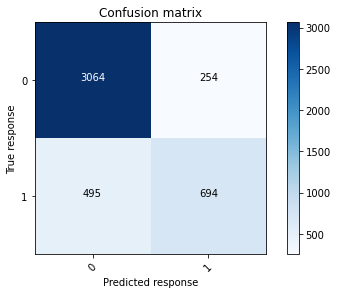

In [15]:
# Print the confusion matrix at a 50% threshold using the training data.
conf_mat_gbm1_train = confusion_matrix(train_gbm_y, train_y_class)
plot_confusion_matrix(conf_mat_gbm1_train, [0, 1])

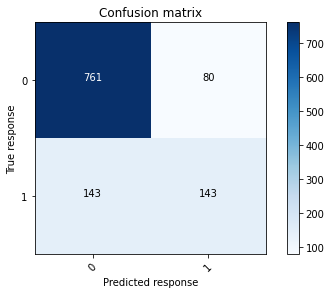

In [16]:
# Print the confusion matrix at a 50% threshold using the validation data.
conf_mat_gbm1_validation = confusion_matrix(validation_gbm_y, validation_y_class)
plot_confusion_matrix(conf_mat_gbm1_validation, [0, 1])

In [17]:
# Calculate the F1 score.
{'train': f1_score(train_gbm_y, train_y_class),
 'validation': f1_score(validation_gbm_y, validation_y_class)}

{'train': 0.6495086569957885, 'validation': 0.5618860510805501}

#### Estimate feature importance

Feature importance provides a measure of how much the model predictions rely on a particular feature. The higher the importance of a feature, the more it contributes to the model's performance.

The code below plot the importance of each feature in the GBM.

<AxesSubplot:title={'center':'Feature importance'}>

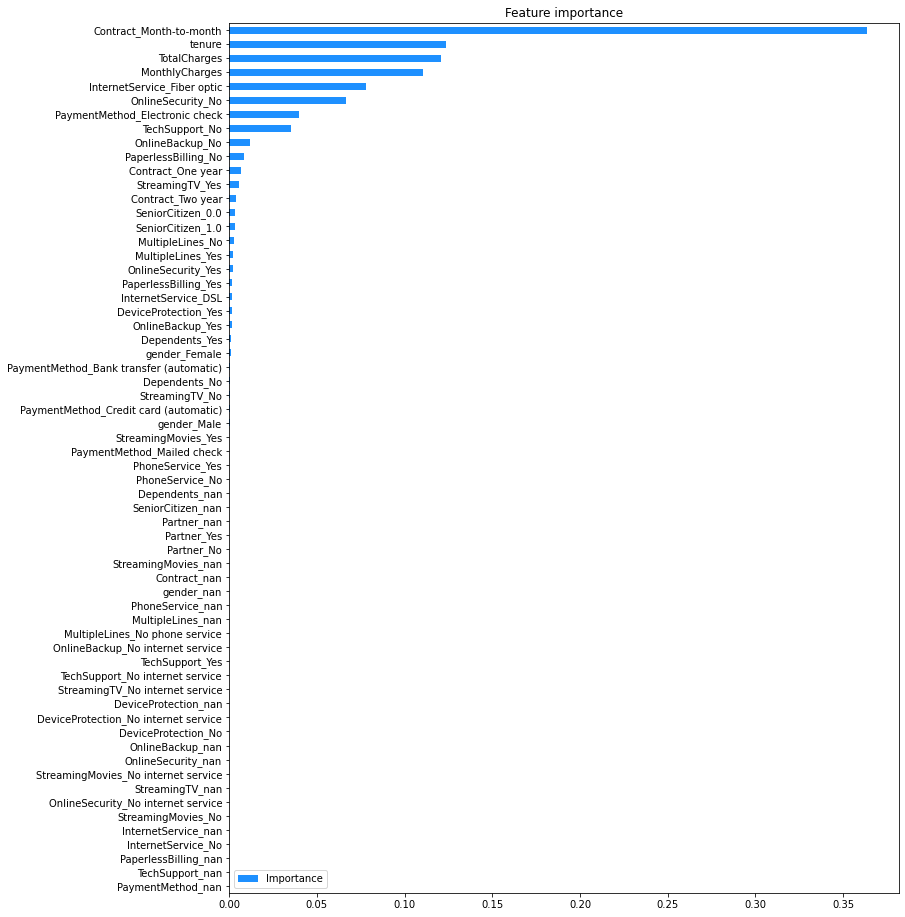

In [18]:
# Create a dictionary with name-importance pairs.
gbm_feat_imps = dict()
for feature, importance in zip(train_gbm_x.columns, gbm_model.feature_importances_):
    gbm_feat_imps[feature] = importance

# Convert to a dataframe and order by importance.
# Note: the feature names become the index for the dataframe, and the importance 
# is the first column (index 0).
gbm_fi = pd.DataFrame.from_dict(gbm_feat_imps, orient = 'index').rename(columns = {0: 'Importance'})
gbm_fi.sort_values(by = 'Importance', inplace = True)

# Plot the feature importances.
gbm_fi.plot(kind = 'barh', \
            figsize = (12,16), \
            title = 'Feature importance', \
            color = 'Dodgerblue'
)

#### Examine effect of features
It is important to understand the shape of the effects learned by the model, in order to:
- understand what the model is doing; and
- assess whether what the model has learned is reasonable given the business context.

A partial dependence plot (PDP) shows how each feature affects a model's predictions. Partial dependence is calculated after a model has been fitted, by examining how the model’s predictions change when the value for one feature (or sometimes two or more features) is changed, with the values of all other features being held constant.

PDPs are used below to visualise the effect shapes for the model's four most important features.

The y-axis of a PDP represents the marginal impact of the feature on the response variable. For example, if the calculated partial dependence is 0 on some part of the PDP line, then for that value of the feature, there is no impact on the response variable, relative to some central tendency of the response variable, which might be its mean or median value.

You are not required to know how to calculate a PDP for this subject. For this case study, you can use the PDPs below to visualise the effect shapes for the model's four most important features.

In [19]:
# Extract the column indices for the four most important features
# on the training data.
gbm_pdp_idx = [i for i in range(len(train_gbm_x.columns)) if \
               train_gbm_x.columns[i] in gbm_fi.tail(4).index.tolist()]
gbm_pdp_idx

[0, 1, 2, 50]

In [20]:
# Check that the right columns have been identified.
train_gbm_x.columns[gbm_pdp_idx]

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month'], dtype='object')

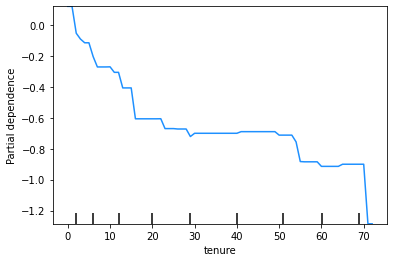

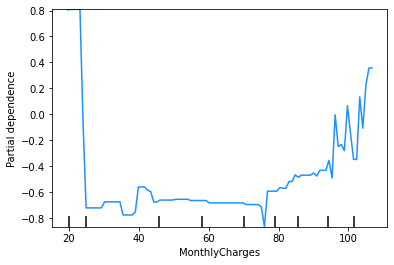

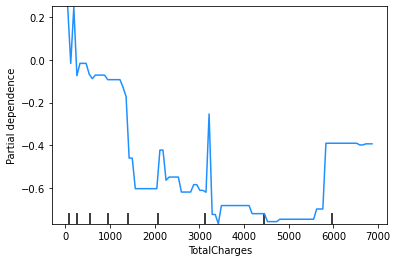

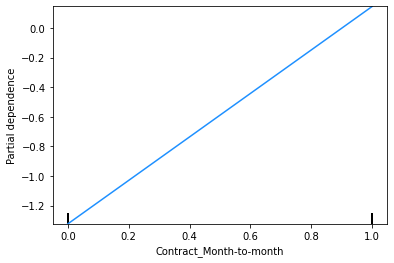

In [21]:
# Produce partial dependence plots.
# Loop over each feature rather than provide a list as this makes it
# easier to plot the data. 
for idx in gbm_pdp_idx:
    plot_partial_dependence(gbm_model, train_gbm_x, features = [idx],
                          line_kw={'color': 'Dodgerblue'})

These plots show that the churn rate:
- decreases with tenure;
- increases with monthly charges;
- has an unclear relationship with total charges (but this will be affected by the correlation between monthly and total charges); and
- increases for those on a monthly contract.


Note that a PDP for a binary feature like ‘Contract_Month-to-month’ is a bit misleading, as the feature can only take values of 0 or 1, so there are only two points on this PDP that make sense. What is important to take away from this PDP is that people on a month-to-month contract are more likely to be predicted to churn than those on a one or two month contract.

This finding can be used to sense check the model’s predictions. In this case, we have already seen from the Explore Data section above that, across the entire dataset, people on a month-to-month contract have a 43% churn rate, compared to 11% for those on a one year contract and 3% for those on a two year contract, so the direction of the PDP outcomes for the feature 'Contract_Month-to-month' makes sense.

#### Improve the model (GBM 2)
Check the documentation for `GradientBoostingClassifier()` to see the hyperparameters available and try a few combinations to improve the performance.

The code below shows some experimentation with hyperparameter values.

In [22]:
# Add additional regularisation by capping the depth of trees at 2 and
# decreasing the learning rate for the model.
# Increase the number of trees (n_estimators) to counter some of the effect
# of the lower learning rate.
gbm_model_v2 = GradientBoostingClassifier(n_estimators = 2000,
                                          learning_rate = 0.01,
                                          max_depth = 2,
                                          validation_fraction = 0.2,
                                          n_iter_no_change = 50,
                                          verbose = 1,
                                          random_state = 1234)
gbm_model_v2.fit(train_gbm_x, train_gbm_y.values.ravel())

      Iter       Train Loss   Remaining Time 
         1           1.1497           11.15s
         2           1.1455           11.07s
         3           1.1414           10.87s
         4           1.1374           10.90s
         5           1.1335           10.63s
         6           1.1296           10.49s
         7           1.1258           10.34s
         8           1.1221           10.46s
         9           1.1185           10.44s
        10           1.1150           10.37s
        20           1.0827            9.94s
        30           1.0556            9.61s
        40           1.0325            9.41s
        50           1.0118            9.35s
        60           0.9929            9.33s
        70           0.9757            9.37s
        80           0.9611            9.42s
        90           0.9483            9.35s
       100           0.9369            9.26s
       200           0.8682            8.70s
       300           0.8394            8.11s
       40

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=2000,
                           n_iter_no_change=50, random_state=1234,
                           validation_fraction=0.2, verbose=1)

#### Evaluate GBM 2

In [23]:
# Score the validation dataset.

# Obtain the predicted churn probabilities, Y_hat.
validation_y_preds_v2 = gbm_model_v2.predict_proba(validation_gbm_x)[:, 1] 

# Obtain the predicted churn outcomes, G(X).
validation_y_class_v2 = gbm_model_v2.predict(validation_gbm_x)

In [24]:
# Compare the AUC on validation data under model 1 ('old') and model 2 ('new').
{'new':roc_auc_score(validation_gbm_y.values.ravel(), validation_y_preds_v2),
 'old':roc_auc_score(validation_gbm_y.values.ravel(), validation_y_preds)}

{'new': 0.861474435196195, 'old': 0.8589570358298064}

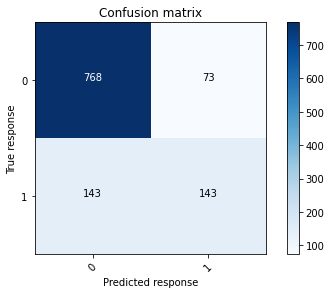

In [25]:
# Plot the confusion matrix at 50% threshold for model 2 - validation data
conf_mat_gbm2_validation = confusion_matrix(validation_gbm_y, validation_y_class_v2)
plot_confusion_matrix(conf_mat_gbm2_validation, [0, 1])

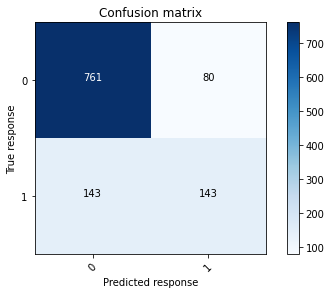

In [26]:
# Plot the confusion matrix at 50% threshold for model 1 - validation data
plot_confusion_matrix(conf_mat_gbm1_validation, [0, 1])

In [27]:
# Compare the F1 score for the two models.
{'new':f1_score(validation_gbm_y, validation_y_class_v2),
 'old':f1_score(validation_gbm_y, validation_y_class)}

{'new': 0.5697211155378485, 'old': 0.5618860510805501}

The AUC and F1 scores shown above indicate that the changes made to create GBM 2 have had some small (relatively immaterial) improvements on the GBM's performance.

#### Select final model (GBM final)


In [28]:
# Select the final model and call it `gbm_model_final`.
gbm_model_final = gbm_model_v2

In [29]:
# Obtain the predicted churn probabilities, Y_hat, for the validation data.
validation_gbm_preds_final = gbm_model_final.predict_proba(validation_gbm_x)[:, 1] 

# Obtain the predicted churn outcomes, G(X) for the validation data.
validation_gbm_class_final = gbm_model_final.predict(validation_gbm_x)

### Simple neural networks built from first principles
In this section a neural network is built from first principles.
While you will not generally need to build a network from first principles, by reviewing the code below, along with Sections 5.5.2, 5.5.3, and 5.5.4 of Module 5, you should obtain a good understanding of what is going on 'under the hood' of a neural network.

To simplify the calculations below:
- the simple neural networks will be limited to at most 1 hidden layer (the first neural network has no hidden layers);
- a sigmoid activation function is used;
- mean-squared error (MSE) is used as the loss function; and
- the loss function is optimised using backpropagation.


#### Prepare data

Categorical features must be encoded as numeric.

The categorical feature with $k$ levels is encoded as follows:
- $k - 1$ binary features are created;
- the $j^{th}$ feature takes the value $1$ if the categorical feature takes the $j^{th}$ level;
- otherwise the $j^{th}$ feature takes the value 0.

In [30]:
# Use the get_dummies() function from the pandas package to produce the encoding.
# The drop_first = True argument tells pandas to drop the binary indicator for 
# the first level, so the function returns k-1 rather than k features.
dataset_nn = pd.get_dummies(dataset, columns=cat_cols, drop_first=True)

In [31]:
# Split the data into train, validation, and test datasets.
train_nn_x, train_nn_y, \
validation_nn_x, validation_nn_y, \
test_nn_x, test_nn_y \
= create_data_splits(dataset_nn, id_col, response_col)

When fitting neural networks it is common to scale the features to a 0-1 range. You can also scale to have standard deviation 1. In this case, only the range is scaled for simplicity.

The response vector also needs to be converted to a numpy array for training the neural network.

In [32]:
# Scale features to lie in [0, 1].
scaler = MinMaxScaler()
scaler.fit(train_nn_x)
input = scaler.transform(train_nn_x)

# Convert the response vector to a Numpy array.
response = train_nn_y.to_numpy()

# Prepare the validation and test datasets also.
response_validation = validation_nn_y.to_numpy()
input_validation = scaler.transform(validation_nn_x)
response_test = test_nn_y.to_numpy()
input_test = scaler.transform(test_nn_x)

#### Fit a single layer neural network (NN 1)

In its simplest form, a neural network can be reduced to a basic regression model (see Exercise 5.16 in Module 5). In the example below, a logistic regression model is constructed within the framework of a single cell neural network.

In this network, the single neuron performs the following operations on the $i^{th}$ training observation (i.e. the $i^{th}$ row of data):
- multiplies the input vector, $X_{i.}$, by the weights for the neuron, $a^{T}$ and adds a bias term $a_0$;
$$f(X_{i.}) = a_0+a^{T}X_{i.}$$

- the output of this linear function is then transformed using a non-linear activation function (in this case the sigmoid function);
$$\hat{y}_{i,1} = sigmoid(f(X_{i.})) = sigmoid(a_0+a^{T}X_{i.})$$ 

As outlined in Section 5.5.2 of Module 5, there are a range of activation functions that can be used, and different problems require different functions.

The output of this first and final neuron is then fed into a loss function. Loss functions are discussed in Section 5.2 of Module 5. For simplicity, the mean-squared error is used here, so that the formula for the loss function is:

$$J = \frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{y}_{i,1})^{2}$$

Backpropagation via gradient descent is then used to minimise this loss function. As described in Section 5.5.4, gradient descent computes the gradients of the loss function with respect to the parameters $a^{T}$ and $a_{0}$. It uses these gradients to iteratively update the model's parameters,  taking small steps towards minimising the loss function.

A single step of gradient descent involves the following computations:
1. Compute the gradients of J with respect to the weights $a_j,  j=0,...,p$, denoted by $\partial a_j$.
2. Update the parameters $a_j, j=0,...,p$ as follows:
$$a_j=a_j-\alpha \partial a_j$$
3. Using the updated parameters, perform another iteration of forward propagation over the entire set of training data to compute the new loss and gradients.
4. Continue iterating for a set number of updates over the entire training dataset, known as epochs.

The diagram below shows the way in which each gradient descent step moves closer to a global minimum for the loss of the model. Note that in the diagram, $w$ refers to $a_j$ and 'cost' refers to 'loss'. 

![grad_descent.png](../_static/daa/grad_descent.png)


<figcaption>Image source: https://medium.com/analytics-vidhya/artificial-neural-networks-part-3-loss-and-cost-functions-and-gradient-descent-76e650bc5162</figcaption>



The parameter $\alpha$ above is the learning rate as described in Section 5.4.2.  In practice, this parameter is very important and will require some experimentation so that the learning rate: 
- is not too small such that the algorithm will take too long to converge to an optimal set of weights; and 
- is not too large such that convergence may not occur at all as the algorithm continually overshoots the minimum point on the loss function.

In [33]:
# Define the sigmoid function (to be used as the activation function).
def sigmoid(x):
  '''
  Sigmoid activation function
  Params:
    x: a float or integer value
  Return:
    The value of the sigmoid function evaluated at x (float)
  '''
  return 1.0/(1.0+np.exp(-x))

The function below defines the first derivative of the sigmoid function which will be used in backpropagation when fitting the neural network. The first derivative of the sigmoid function is given by:

$$
\begin{align} \cr
\frac{d}{dx} \left(\frac{1}{1 + \exp(-x)}\right) &= \frac{\exp(-x)}{(1 + \exp(-x))^2} \cr \cr
 &= sigmoid(x) \times (1 - sigmoid(x))
 \end{align}
$$

The cells below define some functions that will be used to train the model and make predictions.

In [34]:
# Define the first derivative of the sigmoid function.
def dsigmoid(x):
    '''
    Derivative of the sigmoid function evaluated at x
    Params:
    x: value the function will be evaluated at
    Return:
    The value of the function evaluated at x (float)
    '''

    return sigmoid(x)*(1.0 - sigmoid(x))

In [35]:
# Define the mean-squared error loss function.
def mse_loss(response, pred):
    ''' 
    Mean-squared error loss function
    Params:
    response: the vector of responses, Y
    pred: the vector of predicted values, Y_hat
    Return:
    The MSE value (float)
    '''

    return ((response - pred)**2).sum()/response.shape[0]

In [36]:
# Define a function to provide random starting values for the weights and bias term.
def init_params(n_p, n_h = 1, range = 0.1, start = -0.05):
    '''
    Randomly initializes weights and initialises biases to 0
    Params:
    n_p: number of features (size of input array)
    n_h: number of neurons in layer, defaults to 1
    range: range of random initalisation, defaults to 0.1
    start: lowest value of random initialisation, defaults to -0.05
    Returns:
    a0: bias vector
    aT: random weights vector
    '''
    a0 = np.zeros((1, n_h))
    aT = np.random.rand(n_p, n_h) * range + start
    return a0, aT


# Set the random seed for reproducibility.
np.random.seed(1235)

# Initialise the network weights.
# Note that the bias is initialised to zero and weights to a random value
# uniformly in the range [-0.05, 0.05].
# This range is set to match the default for keras (which will be tested later).
bias, weights = init_params(n_p = train_nn_x.shape[1],
                            n_h = 1,
                            range = 0.1,
                            start = -0.05)


In [37]:
# Define a function to perform the forward pass over the data. This will be used
# for training the model. Once the weights have been selected, it will also
# serve as the prediction function.
# The function is fairly simple. The input is a vector with dimension equal to
# the number of features in the dataset (20). There is a single output neuron
# and no hidden layers.
def fwd_pass1(input, bias, weights, keep_intermediate = False):
    '''
    Performs the forward pass calculations for a single neuron network
    Params:
    input: input data frame
    bias: bias parameter
    weights: weights vector
    keep_intermediate: (logical) keep the intermediate results?
                       If True, returns the linear score in addition to the 
                       output value y_hat after the activation function has
                       been applied.
    '''

    # Calculate the value for the neuron on the linear scale,
    # using the sum-product of the inputs and weights, plus the bias term
    f = np.dot(input, weights) + bias

    # Apply the activation function
    y_hat = sigmoid(f)    # final output

    if keep_intermediate:
        return f, y_hat
    else:
        return y_hat

The learning rate and number of training iterations are then defined below.

In [38]:
# Initialise the hyperparameters.

# Set the learning rate - must be in (0, 1].
learn_rate = 0.2

# Set the number of training iterations.
n_rounds = 500

The model can now be trained using the functions and hyperparameters specified above.

In [39]:
# Train the model by implementing the gradient descent algorithm over n_rounds
# of iterations.
for _ in range(n_rounds):

    # Perform a forward propagation.
    f, y_hat = fwd_pass1(input, bias, weights, True)


    # Perform the back-propagation step.
    # This involves calculating the partial derivative of the loss function
    # with respect to the weights.

    # Calculate the partial derivative of the loss function (J)
    # with respect to the output (y_hat_i)
    # J = (y_i - y_hat_i)^2 -> dJ/dy_hat_i = -2(y_i - y_hat_i) = 2(y_hat_i-y_i)
    # In the calculation below, the factor of 2 is dropped as this does not
    # impact the minimum value of the loss function.
    dJ_dyhat = (y_hat-response)

    # Calculate the partial derivate of the output (y_hat_i)
    # with respect to the linear values of the neuron (f(X_i)).
    # The output is simply the activation function applied to the linear values
    # so the derivative is just the derivative of the activation function.
    dyhat_df = dsigmoid(f)

    # The partial derivative of the linear values of the neuron (f(X_i))
    # with respect to the weights is just the inputs (X_i)
    # because linear values (f(X_i))= a1*x1 + a2*x2 + ... 

    # Calculate the gradient of the loss function, excluding the input values
    # because these are constants.
    # This is a useful intermediate calculation step to capture.
    delta = dJ_dyhat*dyhat_df

    # Update the weights.
    weights_old = weights
    weights -= learn_rate * np.dot(input.T, delta) / input.shape[0]

    # Update the bias.
    bias -= learn_rate * np.sum(delta, axis = 0) / input.shape[0]

    # Print the loss calculated after every 25th iteration.
    if np.mod(_, 25) == 0:
        print(f'iter {_} MSE: {mse_loss(response, y_hat)}')

iter 0 MSE: 0.2674449173283448
iter 25 MSE: 0.18042793537210977
iter 50 MSE: 0.1695903881202274
iter 75 MSE: 0.16375575000190337
iter 100 MSE: 0.15956370573799245
iter 125 MSE: 0.1563918167751347
iter 150 MSE: 0.15393250776603987
iter 175 MSE: 0.15198658083135239
iter 200 MSE: 0.15041856028584913
iter 225 MSE: 0.14913420464122898
iter 250 MSE: 0.14806660930424229
iter 275 MSE: 0.1471673599402955
iter 300 MSE: 0.14640079912380527
iter 325 MSE: 0.14574023742870543
iter 350 MSE: 0.1451654004269753
iter 375 MSE: 0.14466067664172322
iter 400 MSE: 0.14421389450896388
iter 425 MSE: 0.14381545501845847
iter 450 MSE: 0.14345770750271378
iter 475 MSE: 0.14313449424136288


#### Evaluate NN 1

The cells below assess the module using the AUC measure and by plotting the confusion matrix.
They also compare the single layer neural network to the final GBM model.

In [40]:
# Now create predictions with the weights from the training step above,
# using the fwd_pass1 function. 
pred_nn1_train = fwd_pass1(input, bias, weights, False)
pred_nn1_validation = fwd_pass1(input_validation, bias, weights, False)

In [41]:
# Print the training and validation AUC.
{'train':roc_auc_score(response, pred_nn1_train),
 'validation':roc_auc_score(response_validation, pred_nn1_validation)}

{'train': 0.8299297457961795, 'validation': 0.8414724395699427}

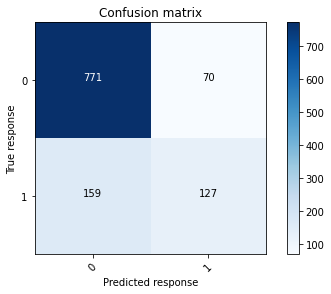

In [42]:
# Plot the confusion matrix, with predictions converted to 
# binary classes using a 50% threshold.
pred_nn1_validation_class = np.where(pred_nn1_validation > 0.5, 1, 0)

conf_mat_nn1_validation = confusion_matrix_new = confusion_matrix(
    response_validation, pred_nn1_validation_class)
plot_confusion_matrix(conf_mat_nn1_validation, [0, 1])

The output from the single layer neural network can now be compared to the output from the final GBM.

In [43]:
{'GBM final':roc_auc_score(response_validation, validation_gbm_preds_final),
 'NN 1': roc_auc_score(response_validation, pred_nn1_validation)}

{'GBM final': 0.861474435196195, 'NN 1': 0.8414724395699427}

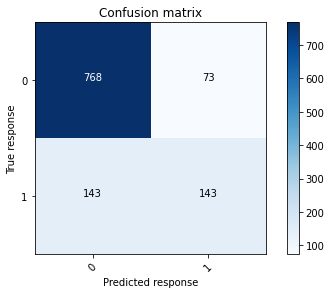

In [44]:
conf_mat_gbm_validation = confusion_matrix(validation_gbm_y, validation_gbm_class_final)
plot_confusion_matrix(conf_mat_gbm_validation, [0, 1])

The AUC is slighly higher (better) under the final GBM than under the single layer neural network. However, the very simple neural network isn't far behind the more complicated GBM and has an AUC above 0.84, so this still seems to be a reasonable model for predicting churn.

#### Fit a multi-layer neural network (NN 2)

The single layer neural network (NN 1) can now be extended to a more complex model in an attempt to improve the predictive capability of the neural network.

This second neural network (NN 2) will have one hidden layer with four neurons. Again, the sigmoid activation function will be used in the hidden and output layers and mean-squared error will be used as the loss function.

For the time-being, this will still be built and trained from first principles. Again, while it will rarely be necessary for you to build a neural network from first principles, you should review the code below to get a better sense of what is going on within a neural network with a hidden layer.

To train this network, the following two steps will again be performed:
1. a forward propagation step to pass the data through the network from start to finish; and
2. a backpropagation step to pass the error back through the network, from the end output (where the error is first observed) to the start of the network (i.e. the input layer).

The neurons in the network's hidden layer perform identical operations to those performed by the single neuron in the first neural network. For example, the first neuron in the hidden layer does the following:
$$f(X_{i.}) = a_{01} + a_{1}^{T}X_{i.} $$
$$Z_{1,1} = \sigma (f(X_{i.})) = \sigma (a_{01} + a_{1}^{T}X_{i.})$$

The sigmoid, dsigmoid, mse_loss and init_params functions that were defined for the purpose of fitting NN 1 can also be used for NN 2.

The following function defines how the forward propagation step should proceed for NN2 that has one hidden layer with four neurons.

In [45]:
def fwd_pass2(input, l1_bias, l1_weights, l2_bias, l2_weights, keep_intermediate = False):
    '''
    Performs the forward propagation calculations for a network with a single hidden layer.
    Params:
    input: input data
    l1_bias: bias for layer 1 (the hidden layer)
    l1_weights: weights for layer 1
    l2_bias: bias for layer 2 (the output layer)
    l2_weights: weights for layer 2
    keep_intermediate: (logical) keep the intermediate results? 
                       If True, returns the linear scores and activations for
                       the hidden and output layers.
    '''

    # Calculate the neurons in layer 1 (the hidden layer).
    f1 = np.matmul(input, l1_weights) + l1_bias # linear score
    z1 = sigmoid(f1)                            # activation

    # Output layer
    f2 = np.dot(z1, l2_weights) + l2_bias       # linear score 
    y_hat = sigmoid(f2)                         # activation: final output

    if keep_intermediate:
        return f1, z1, f2, y_hat
    else:
        return y_hat

The learning rate and number of training iterations are then defined below.

In [46]:
# Set the learning rate - must be in (0, 1].
learn_rate = 0.2

# Set the number of training iterations.
n_rounds = 500

# Specify the desired number of neurons in the hidden layer.
hidden_neurons = 4

# Set the random seed for reproducibility.
np.random.seed(1235)

# Initialise the weights for the hidden layer.
l1_bias, l1_weights = init_params(n_p = input.shape[1], n_h = hidden_neurons, range = 0.1, start = -0.05)

# Initialise the weights for the output layer.
l2_bias, l2_weights = init_params(n_p = l1_weights.shape[1], n_h = 1, range = 0.1, start = -0.05)

The model can now be trained using the functions and hyperparameters specified above.

In [47]:
for _ in range(n_rounds):

    '''
    The model is trained by first performing a forward pass to get the predictions,
    followed by a backward pass to 'propagate' the loss back through each of the
    neurons.
    This is repeated each iteration until the network has converged or 
    the maximum number of rounds has been reached.

    The following notation is used in this function: 
    ln_weights: the weights matrix (one column per neuron) for layer n
    ln_bias: vector of bias values (one per neuron) for layer n
    fn: vector of linear scores (one per neuron) for layer n
    zn: vector of activations (one per neuron) for layer n
    '''

    # Perform the forward pass.
    f1, z1, f2, y_hat = fwd_pass2(input, l1_bias, l1_weights, l2_bias, l2_weights, True)

    # Perform the backpropagation step.
    # Perform the intermediate calculations for the loss function gradients.
    delta2 = (y_hat - response) * dsigmoid(f2)        
    delta1 = np.dot(delta2, l2_weights.T) * dsigmoid(f1)

    dloss_dweight2 = np.dot(z1.T, delta2)/input.shape[0]
    # Gradient with respect to the layer 2 weights.
    dloss_dweight1 = np.matmul(input.T, delta1)/input.shape[0]
    # Gradient with respect to the layer 1 weights.

    # Update the weights.
    l2_weights -= learn_rate * dloss_dweight2
    l1_weights -= learn_rate * dloss_dweight1

    # Update the bias terms.
    l2_bias -= learn_rate * np.sum(delta2, axis = 0) / input.shape[0]
    l1_bias -= learn_rate * np.sum(delta1, axis = 0) / input.shape[0]

    # Print the loss after every 25th iteration.
    if np.mod(_, 25) == 0:
        print('iter', _, ':', mse_loss(response, y_hat))

iter 0 : 0.2511001577139275
iter 25 : 0.21041550733934317
iter 50 : 0.19913895871849857
iter 75 : 0.19548216749243946
iter 100 : 0.1940608216259812
iter 125 : 0.1933855313335157
iter 150 : 0.19298164332895798
iter 175 : 0.19268104914715317
iter 200 : 0.19241961955198858
iter 225 : 0.19217148993015826
iter 250 : 0.19192567962778895
iter 275 : 0.19167721705008536
iter 300 : 0.19142361898305546
iter 325 : 0.19116345236013363
iter 350 : 0.19089573547094899
iter 375 : 0.19061968576294885
iter 400 : 0.19033461306845684
iter 425 : 0.1900398745690468
iter 450 : 0.1897348562620397
iter 475 : 0.18941896598690924


#### Evaluate NN 2

In [48]:
pred_nn2_train = fwd_pass2(input, l1_bias, l1_weights, l2_bias, l2_weights, False)
pred_nn2_validation = fwd_pass2(input_validation, l1_bias, l1_weights, l2_bias, l2_weights, False)

In [49]:
{'train':roc_auc_score(response, pred_nn2_train),
 'validation':roc_auc_score(response_validation, pred_nn2_validation)}

{'train': 0.8136249709132997, 'validation': 0.8250833589715872}

In [50]:
# Compare NN 2 to GBM final and NN 1
{'1. NN 2':roc_auc_score(response_validation, pred_nn2_validation),
 '2. NN 1':roc_auc_score(response_validation, pred_nn1_validation),
 '3. GBM final': roc_auc_score(response_validation, validation_gbm_preds_final)}

{'1. NN 2': 0.8250833589715872,
 '2. NN 1': 0.8414724395699427,
 '3. GBM final': 0.861474435196195}

The slightly more complex neural network with one hidden layer (NN 2) performed slightly worse on the validation data than the very simple one neuron neural network (NN 1). Both performaed slightly worse than the GBM but still had AUCs over 83%.


### Neural networks using Keras

This section demonstrates how to fit a neural network using Python's Keras package. Keras, which runs on top of the TensorFlow library, does all of the calculations shown above for the simple neural networks, taking a lot of the hard work out of building a neural network.

The following steps are used to build the neural networks using Keras:

- use `Sequential()` to specify a feedforward neural network;
- use the `.add()` method to add layers to the network, combined with `Dense()` to specify a dense layer (where all the neurons are fully connected to the preceding layer).

#### Fit a single layer neural network with Keras (NN 3)
The following options are taken to align the first Keras model with NN 2:
- SGD optimiser: this optimises using stochastic gradient descent with momentum. By setting `momentum = 0.0`, `batch_size` to the input data size, and `steps_per_epoch = 1` the basic backpropagation algorithm is recovered.
- `bias_initializer = 'zeros'` and `kernel_initializer = 'random_uniform'`: this sets the initial bias values to 0 and the weights to random uniform (defaulted to a range of [-0.05, 0.05] as used in the simple neural networks above.

In [51]:
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1235)

# Build a model with 1 (dense) hidden layer, 4 neurons and
# a sigmoid activation function.
model = Sequential()
model.add(Dense(4, input_dim = input.shape[1], activation = 'sigmoid', kernel_initializer = 'random_uniform'))
model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_uniform'))

# Specify the optimiser to use.
opt = keras.optimizers.SGD(learning_rate=0.2, momentum=0.0)

# Compile the model using the mean-squared error loss function.
model.compile(
    loss = 'mse',
    metrics = ['mse'],
    optimizer = opt    
)

# Train the model.
model.fit(input, 
          response, 
          epochs = 500, 
          batch_size = input.shape[0],
          steps_per_epoch = 1, 
          verbose = 2)

Epoch 1/500
1/1 - 0s - loss: 0.2531 - mse: 0.2531
Epoch 2/500
1/1 - 0s - loss: 0.2474 - mse: 0.2474
Epoch 3/500
1/1 - 0s - loss: 0.2422 - mse: 0.2422
Epoch 4/500
1/1 - 0s - loss: 0.2375 - mse: 0.2375
Epoch 5/500
1/1 - 0s - loss: 0.2332 - mse: 0.2332
Epoch 6/500
1/1 - 0s - loss: 0.2295 - mse: 0.2295
Epoch 7/500
1/1 - 0s - loss: 0.2261 - mse: 0.2261
Epoch 8/500
1/1 - 0s - loss: 0.2230 - mse: 0.2230
Epoch 9/500
1/1 - 0s - loss: 0.2202 - mse: 0.2202
Epoch 10/500
1/1 - 0s - loss: 0.2178 - mse: 0.2178
Epoch 11/500
1/1 - 0s - loss: 0.2156 - mse: 0.2156
Epoch 12/500
1/1 - 0s - loss: 0.2136 - mse: 0.2136
Epoch 13/500
1/1 - 0s - loss: 0.2118 - mse: 0.2118
Epoch 14/500
1/1 - 0s - loss: 0.2101 - mse: 0.2101
Epoch 15/500
1/1 - 0s - loss: 0.2087 - mse: 0.2087
Epoch 16/500
1/1 - 0s - loss: 0.2073 - mse: 0.2073
Epoch 17/500
1/1 - 0s - loss: 0.2061 - mse: 0.2061
Epoch 18/500
1/1 - 0s - loss: 0.2051 - mse: 0.2051
Epoch 19/500
1/1 - 0s - loss: 0.2041 - mse: 0.2041
Epoch 20/500
1/1 - 0s - loss: 0.2032 - m

Epoch 161/500
1/1 - 0s - loss: 0.1913 - mse: 0.1913
Epoch 162/500
1/1 - 0s - loss: 0.1913 - mse: 0.1913
Epoch 163/500
1/1 - 0s - loss: 0.1913 - mse: 0.1913
Epoch 164/500
1/1 - 0s - loss: 0.1912 - mse: 0.1912
Epoch 165/500
1/1 - 0s - loss: 0.1912 - mse: 0.1912
Epoch 166/500
1/1 - 0s - loss: 0.1912 - mse: 0.1912
Epoch 167/500
1/1 - 0s - loss: 0.1912 - mse: 0.1912
Epoch 168/500
1/1 - 0s - loss: 0.1912 - mse: 0.1912
Epoch 169/500
1/1 - 0s - loss: 0.1911 - mse: 0.1911
Epoch 170/500
1/1 - 0s - loss: 0.1911 - mse: 0.1911
Epoch 171/500
1/1 - 0s - loss: 0.1911 - mse: 0.1911
Epoch 172/500
1/1 - 0s - loss: 0.1911 - mse: 0.1911
Epoch 173/500
1/1 - 0s - loss: 0.1911 - mse: 0.1911
Epoch 174/500
1/1 - 0s - loss: 0.1910 - mse: 0.1910
Epoch 175/500
1/1 - 0s - loss: 0.1910 - mse: 0.1910
Epoch 176/500
1/1 - 0s - loss: 0.1910 - mse: 0.1910
Epoch 177/500
1/1 - 0s - loss: 0.1910 - mse: 0.1910
Epoch 178/500
1/1 - 0s - loss: 0.1910 - mse: 0.1910
Epoch 179/500
1/1 - 0s - loss: 0.1909 - mse: 0.1909
Epoch 180/50

Epoch 319/500
1/1 - 0s - loss: 0.1873 - mse: 0.1873
Epoch 320/500
1/1 - 0s - loss: 0.1873 - mse: 0.1873
Epoch 321/500
1/1 - 0s - loss: 0.1872 - mse: 0.1872
Epoch 322/500
1/1 - 0s - loss: 0.1872 - mse: 0.1872
Epoch 323/500
1/1 - 0s - loss: 0.1872 - mse: 0.1872
Epoch 324/500
1/1 - 0s - loss: 0.1871 - mse: 0.1871
Epoch 325/500
1/1 - 0s - loss: 0.1871 - mse: 0.1871
Epoch 326/500
1/1 - 0s - loss: 0.1871 - mse: 0.1871
Epoch 327/500
1/1 - 0s - loss: 0.1870 - mse: 0.1870
Epoch 328/500
1/1 - 0s - loss: 0.1870 - mse: 0.1870
Epoch 329/500
1/1 - 0s - loss: 0.1870 - mse: 0.1870
Epoch 330/500
1/1 - 0s - loss: 0.1869 - mse: 0.1869
Epoch 331/500
1/1 - 0s - loss: 0.1869 - mse: 0.1869
Epoch 332/500
1/1 - 0s - loss: 0.1869 - mse: 0.1869
Epoch 333/500
1/1 - 0s - loss: 0.1868 - mse: 0.1868
Epoch 334/500
1/1 - 0s - loss: 0.1868 - mse: 0.1868
Epoch 335/500
1/1 - 0s - loss: 0.1868 - mse: 0.1868
Epoch 336/500
1/1 - 0s - loss: 0.1867 - mse: 0.1867
Epoch 337/500
1/1 - 0s - loss: 0.1867 - mse: 0.1867
Epoch 338/50

Epoch 477/500
1/1 - 0s - loss: 0.1811 - mse: 0.1811
Epoch 478/500
1/1 - 0s - loss: 0.1810 - mse: 0.1810
Epoch 479/500
1/1 - 0s - loss: 0.1810 - mse: 0.1810
Epoch 480/500
1/1 - 0s - loss: 0.1809 - mse: 0.1809
Epoch 481/500
1/1 - 0s - loss: 0.1809 - mse: 0.1809
Epoch 482/500
1/1 - 0s - loss: 0.1808 - mse: 0.1808
Epoch 483/500
1/1 - 0s - loss: 0.1808 - mse: 0.1808
Epoch 484/500
1/1 - 0s - loss: 0.1808 - mse: 0.1808
Epoch 485/500
1/1 - 0s - loss: 0.1807 - mse: 0.1807
Epoch 486/500
1/1 - 0s - loss: 0.1807 - mse: 0.1807
Epoch 487/500
1/1 - 0s - loss: 0.1806 - mse: 0.1806
Epoch 488/500
1/1 - 0s - loss: 0.1806 - mse: 0.1806
Epoch 489/500
1/1 - 0s - loss: 0.1805 - mse: 0.1805
Epoch 490/500
1/1 - 0s - loss: 0.1805 - mse: 0.1805
Epoch 491/500
1/1 - 0s - loss: 0.1804 - mse: 0.1804
Epoch 492/500
1/1 - 0s - loss: 0.1804 - mse: 0.1804
Epoch 493/500
1/1 - 0s - loss: 0.1803 - mse: 0.1803
Epoch 494/500
1/1 - 0s - loss: 0.1803 - mse: 0.1803
Epoch 495/500
1/1 - 0s - loss: 0.1802 - mse: 0.1802
Epoch 496/50

In [52]:
# Obtain the predictions on the training and validation data.
keras_train_preds = model.predict(input)
keras_validation_preds = model.predict(input_validation)

#### Evaluate NN 3

In [53]:
# Calculate the AUC on the training and validation data.
{'train':roc_auc_score(response, keras_train_preds), 'validation':roc_auc_score(response_validation, keras_validation_preds)}

{'train': 0.8112781367883518, 'validation': 0.8222811671087532}

In [54]:
# Compare the AUCs under all models built to date.
{'1. NN 3': roc_auc_score(response_validation, keras_validation_preds),
 '2. NN 2': roc_auc_score(response_validation, pred_nn2_validation),
 '3. NN 1': roc_auc_score(response_validation, pred_nn1_validation),
 '4. GBM final': roc_auc_score(response_validation, validation_gbm_preds_final)}

{'1. NN 3': 0.8222811671087532,
 '2. NN 2': 0.8250833589715872,
 '3. NN 1': 0.8414724395699427,
 '4. GBM final': 0.861474435196195}

As expected, the AUC for NN 3 (Neural network with 4 hidden neurons using Keras) is very similar to that for NN 2 (neural network with 4 hidden neurons built from first principles). All three neural networks underperform the GBM final model. 

#### Fit a more complex model with Keras

Now, the power of Keras will be used to easily extend the simple single hidden layer model into a more complex neural network.

There are many features available in Keras. The code below makes the following relatively simple adjustments to NN 3:
- add a second hidden (dense) layer;
- increase the number of neurons in each hidden layer to eight;
- use a ReLU activation function for the hidden layers;
- apply regularisation to the weights to avoid the model overfitting to the training data;
- use a binary cross-entropy loss (logistic loss for a binary classifier); and
- use the more advanced Adam optimizer, in place of standard backpropagation.

Details of these options and more can be found on the keras webpage: https://keras.io/

In [55]:
np.random.seed(1235)

# Construct the adjusted neural network model.
model2 = Sequential()
model2.add(Dense(8, input_dim= input.shape[1], activation='relu', kernel_regularizer='l2'))
model2.add(Dense(8, activation='relu', kernel_regularizer='l2'))
model2.add(Dense(1, activation='sigmoid'))
# Compile the model using the Adam optimiser and the logistic loss function
# for a binary classifier (binary_cross_entropy).
model2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_crossentropy'],
)
model2.fit(input, response, epochs=100, batch_size=1000)


Epoch 1/100
5/5 [==============================] - 0s 2ms/step - loss: 1.0556 - binary_crossentropy: 0.8496
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 1.0217 - binary_crossentropy: 0.8192
Epoch 3/100
5/5 [==============================] - 0s 2ms/step - loss: 0.9922 - binary_crossentropy: 0.7932
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.9665 - binary_crossentropy: 0.7710
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 0.9437 - binary_crossentropy: 0.7518
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 0.9236 - binary_crossentropy: 0.7353
Epoch 7/100
5/5 [==============================] - 0s 1ms/step - loss: 0.9055 - binary_crossentropy: 0.7208
Epoch 8/100
5/5 [==============================] - 0s 1ms/step - loss: 0.8894 - binary_crossentropy: 0.7083
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 0.8748 - binary_crossentropy: 0.6973
Epoch 10/100
5/5 [==========

5/5 [==============================] - 0s 1ms/step - loss: 0.5014 - binary_crossentropy: 0.4446
Epoch 77/100
5/5 [==============================] - 0s 1ms/step - loss: 0.5000 - binary_crossentropy: 0.4441
Epoch 78/100
5/5 [==============================] - 0s 1ms/step - loss: 0.4987 - binary_crossentropy: 0.4437
Epoch 79/100
5/5 [==============================] - 0s 1ms/step - loss: 0.4975 - binary_crossentropy: 0.4433
Epoch 80/100
5/5 [==============================] - 0s 2ms/step - loss: 0.4963 - binary_crossentropy: 0.4429
Epoch 81/100
5/5 [==============================] - 0s 1ms/step - loss: 0.4950 - binary_crossentropy: 0.4424
Epoch 82/100
5/5 [==============================] - 0s 1ms/step - loss: 0.4938 - binary_crossentropy: 0.4420
Epoch 83/100
5/5 [==============================] - 0s 1ms/step - loss: 0.4926 - binary_crossentropy: 0.4416
Epoch 84/100
5/5 [==============================] - 0s 1ms/step - loss: 0.4915 - binary_crossentropy: 0.4411
Epoch 85/100
5/5 [==============

In [56]:
# Obtain the predictions on the training and validation data.
keras2_train_preds = model2.predict(input)
keras2_validation_preds = model2.predict(input_validation)

#### Evaluate NN 4

In [57]:
# Calculate the AUC on the training and validation data.
{'train':roc_auc_score(response, keras2_train_preds), 'validation':roc_auc_score(response_validation, keras2_validation_preds)}

{'train': 0.8345909687506179, 'validation': 0.8480247457655306}

In [58]:
# Calculate the relative improvement in AUC between NN 4 and NN 3
# using the validation data.
roc_auc_score(response_validation, keras2_validation_preds) / roc_auc_score(response_validation, keras_validation_preds)


1.031307513398726

The modifications made to the first Keras model (NN 3) to produce NN 4 have resulted in a slight improvement in the AUC.

In [59]:
# Compare the results of all five models built in this notebook.
{'1. NN 4 (Keras2)': roc_auc_score(response_validation, keras2_validation_preds),
 '2. NN 3 (Keras1)': roc_auc_score(response_validation, keras_validation_preds),
 '3. NN 2': roc_auc_score(response_validation, pred_nn2_validation),
 '4. NN 1': roc_auc_score(response_validation, pred_nn1_validation),
 '5. GBM final': roc_auc_score(response_validation, validation_gbm_preds_final)}

{'1. NN 4 (Keras2)': 0.8480247457655306,
 '2. NN 3 (Keras1)': 0.8222811671087532,
 '3. NN 2': 0.8250833589715872,
 '4. NN 1': 0.8414724395699427,
 '5. GBM final': 0.861474435196195}

## Evaluation and observations

The Keras model provides the best performance (based on AUC) of the neural networks, but still underperforms the GBM.

As an exercise, play around with some of the features available in Keras and try to build a neural network that outperforms the GBM on the validation data.

You should note that the test data (20% of the original dataset) was not used in any of the modelling above. This is because it should be held-out until a final model has been selected. The test data can then be used to estimate the expected error of the final model on unseen data.